### Ejercicios del tema de Reducción de Dimensionalidad

*Hugo Díaz Díaz* (*hdiazd00@estudiantes.unileon.es*)

*Correo profesional: hugo.didi.contacto@gmail.com*

---


## Parte teórica (opcional)

### 1. ¿Cuáles son las principales motivaciones para reducir la dimensionalidad de un conjunto de datos? ¿Cuáles son las principales desventajas?

La motivación principal es que muchos problemas tienen demasiadas características. Esto hace que entrenar sea mucho más lento y que sea más difícil encontrar una buena solución. Reducir la dimensionalidad suele convertir un problema pesado en uno manejable. También ayuda mucho a visualizar, porque si bajas a 2D o 3D puedes ver patrones y agrupaciones que en alta dimensión no se ven tan claro.
La desventaja es que casi siempre pierdes información. Es como comprimir, ganas velocidad y simplicidad, pero puede bajar un poco el rendimiento. Por eso suele tener sentido comparar el modelo con y sin reducción.

### 2. ¿Qué es la maldición de la dimensionalidad?

Es el conjunto de problemas que aparecen cuando tienes muchas dimensiones. El entrenamiento se vuelve lento, necesitas más datos para generalizar bien y es más fácil que el modelo se complique o se vuelva inestable.

### 3. Una vez reducida la dimensionalidad de un conjunto de datos, ¿es posible revertir la operación? Si es así, ¿cómo? Si no, ¿por qué?

Se puede reconstruir una aproximación en el espacio original. En PCA, por ejemplo, proyectas a menos dimensiones y luego aplicas la transformación inversa para volver a la dimensión original.
Pero no recuperas exactamente lo mismo, porque lo que se elimina en la proyección se pierde. Esa pérdida se nota como error de reconstrucción.

### 4. ¿Se puede usar PCA para reducir la dimensionalidad de un conjunto de datos altamente no lineal?

PCA clásico es lineal. En datos altamente no lineales puede fallar, porque aplasta la estructura y mezcla partes que en realidad están separadas. Un ejemplo típico es Swiss roll.
En esos casos suele funcionar mejor Kernel PCA, porque permite reducciones no lineales usando kernels, o métodos de aprendizaje de variedades como LLE.

### 5. Supón que aplicas PCA a un conjunto de datos de 1.000 dimensiones, fijando el ratio de varianza explicada en el 95%. ¿Cuántas dimensiones tendrá el conjunto de datos resultante?

No se puede saber un número fijo solo con “1.000 dimensiones”: el resultado es el mínimo `d` tal que la suma acumulada de `explained_variance_ratio_` alcanza el 95%. En MNIST, por ejemplo, con el 95% salen 154 componentes (pero eso depende totalmente del dataset).

### 6. ¿En qué casos usarías PCA estándar (vanilla), PCA incremental, PCA aleatorizado o PCA con kernel?

Usaría:

- PCA normal cuando puedo cargar los datos en memoria y quiero una reducción lineal estándar.

- Randomized PCA cuando busco acelerar el cálculo de los componentes principales, sobre todo si solo necesito los primeros.

- Incremental PCA cuando el dataset no cabe en memoria o quiero procesarlo por mini-lotes.

- Kernel PCA cuando necesito capturar estructura no lineal y una proyección lineal se queda corta.

### 7. ¿Cómo puedes evaluar el rendimiento de un algoritmo de reducción de dimensionalidad en tu conjunto de datos?

Si es un método como PCA, se puede mirar el error de reconstrucción, que mide cuánto cambia el dato al comprimir y reconstruir. También se puede revisar cuánta varianza estás preservando.

Si la reducción es un paso antes de un modelo, lo más útil es comparar tiempo de entrenamiento y rendimiento en test, con y sin reducción.

Si el objetivo es visualización, se reduce a 2D y se comprueba si aparecen clusters más claros y separados, comparándolo con otros métodos.

### 8. ¿Tiene sentido encadenar dos algoritmos distintos de reducción de dimensionalidad?

Puede tener sentido, pero no siempre. Cada reducción puede perder información, así que encadenarlas puede empeorar eso si se hace sin cuidado.
Aun así, hay casos razonables. Por ejemplo, primero haces una reducción rápida y lineal para bajar el problema a algo manejable, y luego aplicas un método no lineal para visualizar mejor o capturar una estructura más compleja.

---

## Parte práctica

### Ejercicio 9 (obligatorio)

Cargar el conjunto de datos MNIST y dividirlo en entrenamiento y test (tomar las primeras 60.000 instancias para entrenamiento y las 10.000 restantes para test). Entrenar un clasificador Random Forest sobre el conjunto y medir cuánto tarda, y después evaluarlo en test. A continuación, aplicar PCA para reducir la dimensionalidad con un 95% de varianza explicada. Entrenar un nuevo Random Forest con el conjunto reducido y medir el tiempo. ¿Fue mucho más rápido? Evaluar en test y comparar con el modelo anterior. Repetir el proceso con un SGDClassifier. ¿Cuánto ayuda PCA ahora?

Vamos a empezar importando las librerías necesarias:

In [9]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [10]:
import time

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

Se define una función auxiliar para medir el tiempo de entrenamiento y guardarlo en una variable:

In [11]:
def fit_timed(model, X, y):
    t0 = time.perf_counter()
    model.fit(X, y)
    t1 = time.perf_counter()
    return model, (t1 - t0)

Se carga el conjunto de datos MNIST y se divide en entrenamiento y test:

In [12]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
y = mnist["target"]

X.shape, y.shape

((70000, 784), (70000,))

In [13]:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

X_train.shape, X_test.shape

((60000, 784), (10000, 784))


---

#### **Parte A** (RF sin PCA)

En primer lugar, se entrena un **Random Forest** sobre los datos originales y se mide el tiempo de entrenamiento:

In [14]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf, t_rf = fit_timed(rf, X_train, y_train)

t_rf 

9.147629199998846

`Obtenido por el autor: ~8.53`

Accuracy:

In [15]:
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
acc_rf


0.9705


---

#### **Parte B** (RF con PCA)

Ahora se ajusta **PCA completo** para calcular el número mínimo de componentes que alcanza el 95% de varianza explicada acumulada.

In [16]:
pca_full = PCA()
pca_full.fit(X_train)

cumsum = np.cumsum(pca_full.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

np.int64(154)

Entonces se obtienen 154 componentes principales que explican el 95% de la varianza. De esta forma, se reduce la dimensionalidad de los datos de 784 a 154 dimensiones. Sirve de referencia aunque luego no es necesario ya que durante el entrenamiento ya se deduce este número de componentes directamente.

Se entrena PCA directo con el criterio del 95%:


In [17]:
pca = PCA(n_components=0.95)
X_train_red = pca.fit_transform(X_train)
X_test_red = pca.transform(X_test)

pca.n_components_, X_train_red.shape, X_test_red.shape

(np.int64(154), (60000, 154), (10000, 154))

(Como se ve, se llega al mismo número de componentes (154) que con PCA completo.)

Se entrena un **Random Forest** sobre los datos reducidos y se mide el tiempo de entrenamiento:

In [18]:
rf_pca = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_pca, t_rf_pca = fit_timed(rf_pca, X_train_red, y_train)
t_rf_pca


18.982231499998306

`Obtenido por el autor: ~19.17 s`

Entrenar con PCA, no ha sido más rápido. Esto puede pasar, aunque haya menos dimensiones, tras PCA los datos pasan a ser una matriz densa de floats y el árbol no siempre “se beneficia” como un modelo lineal. Además, aquí se está midiendo solo el fit del Random Forest, pero en el flujo real todavía habría que sumar el coste de entrenar PCA y transformar, con lo que el pipeline completo sería aún menos favorable para RF.

In [19]:
y_pred_rf_pca = rf_pca.predict(X_test_red)
acc_rf_pca = accuracy_score(y_test, y_pred_rf_pca)
acc_rf_pca


0.9488

Con estos resultados, aplicar PCA (95%) antes de entrenar el Random Forest no compensa: el entrenamiento no solo no se acelera, sino que se vuelve claramente más lento, y además la precisión en test baja de forma apreciable respecto al modelo original. En conjunto, aquí PCA está eliminando información útil y no está dando el beneficio de cómputo que se buscaba, así que para este caso concreto es mejor quedarse con el Random Forest sin reducción.

Comparación de resultados:

In [20]:
speedup_rf = t_rf / t_rf_pca
delta_acc_rf = acc_rf_pca - acc_rf

speedup_rf, delta_acc_rf


(0.4819048382167114, -0.021700000000000053)

El modelo con PCA ha empeorado en precisión y ha tardado más en entrenar. Casi el doble de lento al entrenar y pierde algo mas de un 2% en accuracy.


--- 

#### **Parte C** (SGDClassifier sin PCA)

En este bloque se usa estandarización antes de SGD, ya que SGD es muy sensible a la escala de las características. Se mantiene el estilo de “pipeline” para que el experimento sea limpio.

Se define y entrena el **SGDClassifier** sobre los datos originales y se mide el tiempo de entrenamiento:

In [21]:
sgd_base = make_pipeline(
    StandardScaler(),
    SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
)

sgd_base, t_sgd = fit_timed(sgd_base, X_train, y_train)
t_sgd


389.6561472000012

`Obtenido por el autor: ~410.78 s (~6m 50s) `

Y se mide la precisión en test:

In [22]:
y_pred_sgd = sgd_base.predict(X_test)
acc_sgd = accuracy_score(y_test, y_pred_sgd)
acc_sgd


0.8894

Vemos que de por sí el SGDClassifier tarda mucho más en entrenar que el Random Forest sin reducción, aunque consigue una precisión inferior.


---

#### **Parte D** (SGDClassifier con PCA)

Ahora se inserta PCA en el pipeline manteniendo la misma lógica del 95% de varianza.

In [23]:
sgd_pca = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95),
    SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
)

sgd_pca, t_sgd_pca = fit_timed(sgd_pca, X_train, y_train)
t_sgd_pca


228.30655520000073

`Obtenido por el autor: ~244.23 s (~4m 4s) `

In [24]:
y_pred_sgd_pca = sgd_pca.predict(X_test)
acc_sgd_pca = accuracy_score(y_test, y_pred_sgd_pca)
acc_sgd_pca


0.8938

Ahora se cuantifica el efecto de PCA en SGD.

In [25]:
speedup_sgd = t_sgd / t_sgd_pca
delta_acc_sgd = acc_sgd_pca - acc_sgd

speedup_sgd, delta_acc_sgd

(1.7067234309529802, 0.0044000000000000705)

En el caso de SGDClassifier sí se ve el efecto esperado de PCA. Al reducir la dimensionalidad, el entrenamiento se acelera de forma clara (aprox. 1.7×), y la precisión prácticamente se mantiene, incluso con una ligera mejora. Esto encaja con que SGD es un modelo lineal cuyo coste depende mucho del número de características, así que pasar de 784 a ~150 componentes reduce bastante el trabajo por iteración sin “romper” la información útil para clasificar. En resumen, para SGD, PCA ayuda sobre todo en tiempo y no penaliza el rendimiento.

#### CONCLUSIONES

Comparando ambos modelos, la utilidad de PCA depende totalmente del clasificador. En Random Forest, PCA no solo no acelera, sino que empeora claramente el tiempo de entrenamiento y además baja la accuracy, así que aquí no compensa y el modelo sin reducción es mejor tanto por coste como por rendimiento. En cambio, con SGDClassifier PCA sí aporta valor, porque reduce el tiempo de cómputo de forma notable manteniendo la precisión prácticamente igual. Por tanto, respondiendo al enunciado, el entrenamiento no fue “mucho más rápido” en general: con Random Forest fue peor, mientras que con SGD sí se obtuvo una aceleración real. La comparación en test también refleja lo mismo: PCA degrada Random Forest, pero en SGD no perjudica (y puede incluso mejorar ligeramente), así que PCA ayuda “de verdad” cuando el modelo es sensible al número de variables y se beneficia de trabajar en un espacio más compacto.

`Aclarar que los valores de tiempo que se mencionan pueden variar en cada ejecución dependiendo de la carga del sistema y otros factores externos. Los tiempos indicados son de referencia y se han obtenido en una ejecución específica del código.`


---

---

### Ejercicio 10 (opcional)

Usar t-SNE para reducir el dataset MNIST a dos dimensiones y representarlo con Matplotlib. Se puede hacer un scatter con 10 colores (una clase por dígito). Alternativamente, escribir dígitos coloreados en cada punto o dibujar mini-imágenes (si se dibujan todas quedará muy cargado, así que conviene muestrear o evitar poner dos instancias muy cercanas). Debería verse una visualización “bonita” con clusters bien separados. Probar otros métodos como PCA, LLE o MDS y comparar las visualizaciones.

En este ejercicio se reutilizan `X_train`, `y_train` (MNIST 60k). Para visualización, se toma un subconjunto aleatorio porque t-SNE y MDS escalan mal en coste si se meten los 60.000 puntos. Se selecciona un subconjunto representativo de entrenamiento para visualizar (por ejemplo 10.000). Con 10k suele ser razonable y ya aparece bien la estructura.

In [26]:
np.random.seed(42)

m = 10_000
idx = np.random.permutation(len(X_train))[:m]
X_vis = X_train[idx]
y_vis = y_train[idx]



---

#### **A** (t-SNE)

Primero se aplica una reducción previa con PCA a 50 dimensiones. Esto no cambia el objetivo final (2D), pero suele ayudar a eliminar ruido y a acelerar t-SNE sin perder demasiado contenido visual.

In [27]:
pca_50 = PCA(n_components=50, random_state=42)
X_vis_50 = pca_50.fit_transform(X_vis)

Ahora se ejecuta t-SNE a 2D. Un ajuste típico es perplexity=30. Si se sube la perplexity tiende a agrupar más globalmente, si se baja tiende a fragmentar más.

In [28]:
tsne = TSNE(
    n_components=2,
    random_state=42,
    init="pca",
    learning_rate="auto",
    perplexity=30
)
X_tsne = tsne.fit_transform(X_vis_50)


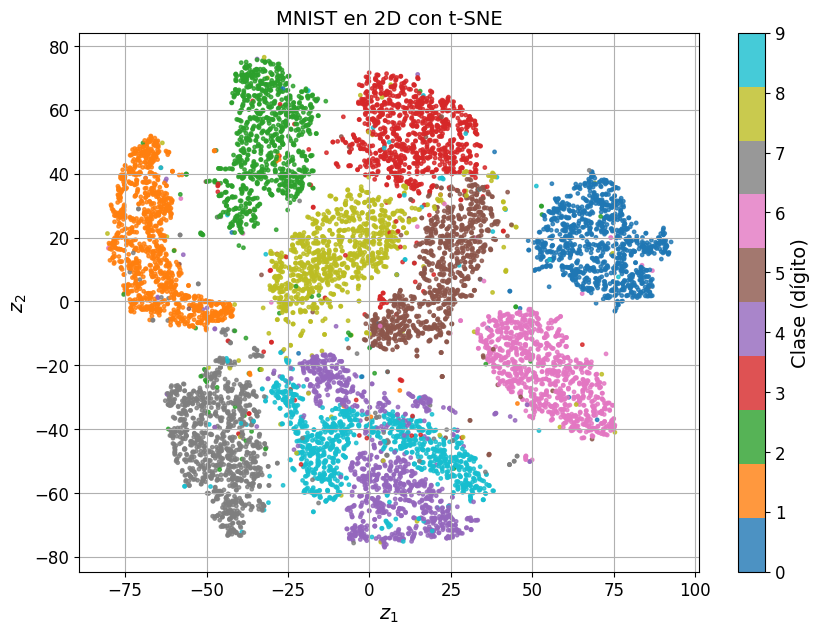

In [29]:
plt.figure(figsize=(10, 7))
sc = plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    c=y_vis, cmap=plt.cm.tab10,
    s=6, alpha=0.8
)
cb = plt.colorbar(sc, ticks=range(10))
cb.set_label("Clase (dígito)")
plt.title("MNIST en 2D con t-SNE", fontsize=14)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.grid(True)
plt.show()


Se ven 10 grupos/clusters bien definidos. Los peor separados son el 4 y el 9, que tienen cierta superposición, pero en general la separación es buena. Estos problemas son típicos y lógicos en dígitos que se parecen, especialmente si las similaridades se produces en mayor medida en esta fracción reducida del dataset. Aparecen en menor medida en 3/5/8, pero es más bien a nivel de frontera que solapamiento.


---

#### **B** (PCA)

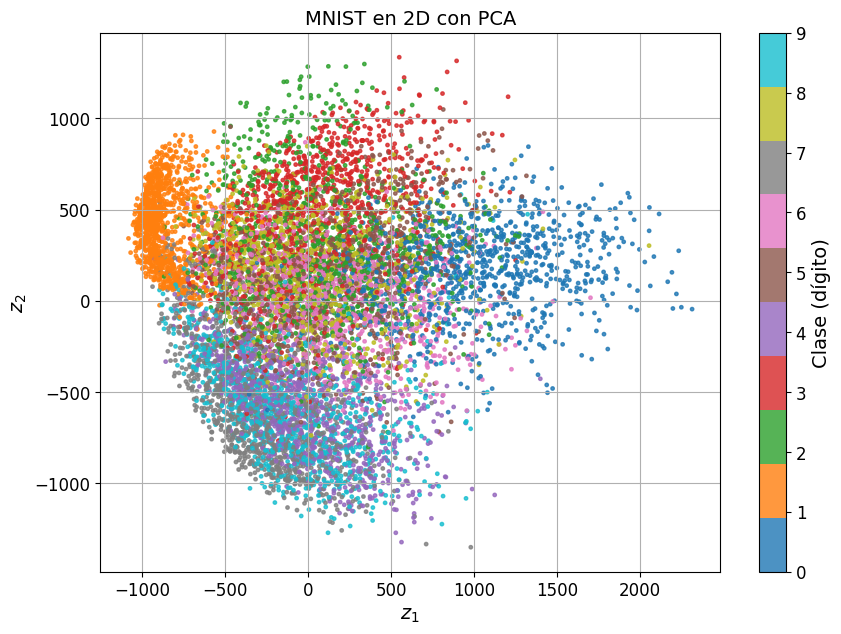

In [30]:
pca_2 = PCA(n_components=2, random_state=42)
X_pca2 = pca_2.fit_transform(X_vis)

plt.figure(figsize=(10, 7))
sc = plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=y_vis, cmap=plt.cm.tab10, s=6, alpha=0.8)
plt.colorbar(sc, ticks=range(10)).set_label("Clase (dígito)")
plt.title("MNIST en 2D con PCA", fontsize=14)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.grid(True)
plt.show()


Con PCA se obtiene una visualización mucho peor. Los clusters no están bien separados y hay mucha superposición. PCA es lineal y no captura bien la estructura compleja de los dígitos escritos a mano, así que la proyección a 2D no refleja bien las diferencias entre clases.


---

#### **C** (LLE)

Se redujo el tamaño de los datos de entrenamiento para agilizar el cálculo. LLE puede ser pesado en 10k dependiendo del equipo. Se debe tener en cuenta que LLE usa vecinos cercanos para preservar la estructura local, lo que puede ayudar a mantener la forma de los datos en la reducción. Es muy sensible al parámetro n_neighbors, aquí se ha usado 20 como valor razonable.

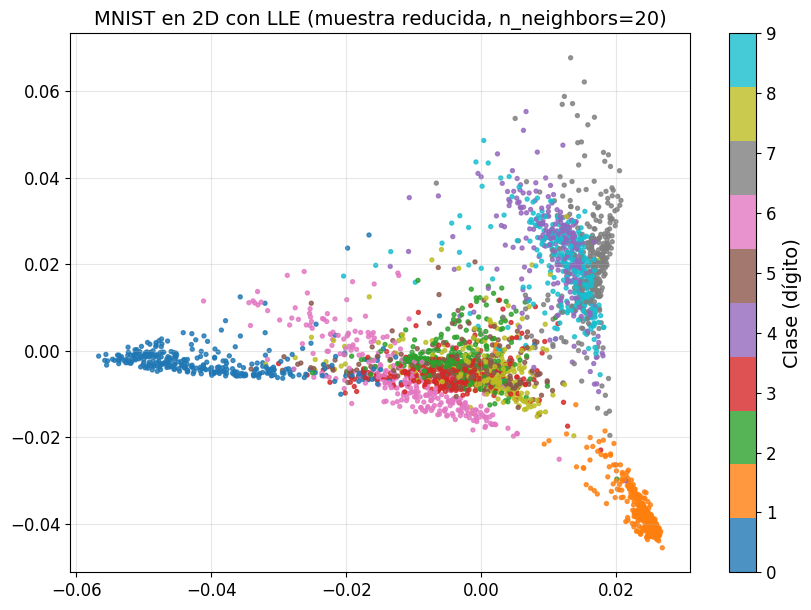

In [41]:
m_lle = 3000
idx_lle = np.random.permutation(len(X_train))[:m_lle]
X_lle_in = X_train[idx_lle]
y_lle = y_train[idx_lle]

lle = LocallyLinearEmbedding(
    n_components=2,
    n_neighbors=20,
    method="modified",  #algo más estable que "standard"
    random_state=42
)

X_lle_2d = lle.fit_transform(X_lle_in)

plt.figure(figsize=(10, 7))
sc = plt.scatter(X_lle_2d[:, 0], X_lle_2d[:, 1], c=y_lle, cmap=plt.cm.tab10, s=8, alpha=0.8)
plt.colorbar(sc, ticks=range(10)).set_label("Clase (dígito)")
plt.title(f"MNIST en 2D con LLE (muestra reducida, n_neighbors={lle.n_neighbors})", fontsize=14)
plt.grid(True, alpha=0.3)

Se observa una  proyección con cierta estructura y regiones dominadas por algunas clases, pero con más mezcla que t-SNE. Una mejora posible sería aplicar un PCA previo (por ejemplo a 50 componentes) antes de LLE para estabilizar los vecindarios y reducir ruido, pero aquí se deja como recomendación y no se aplica en el código principal.


---

#### D (MDS)

MDS intenta preservar distancias globales, pero su coste escala muy mal. Por eso, de nuevo se redujo el tamaño de los datos de entrenamiento para agilizar el cálculo.

c:\Users\hugod\OneDrive\Escritorio\muria\muria-machinelearning\DimensionalityReduction\.venv\Lib\site-packages\sklearn\manifold\_mds.py:754: FutureWarning: The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.
  warnings.warn(


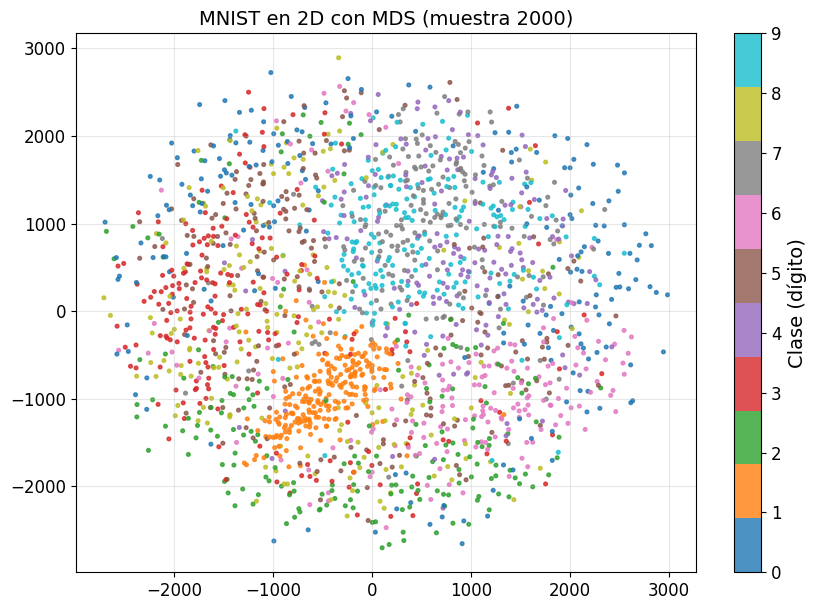

In [42]:
from sklearn.manifold import MDS

m_mds = 2000
idx_mds = np.random.permutation(len(X_train))[:m_mds]
X_mds_in = X_train[idx_mds]
y_mds = y_train[idx_mds]

mds = MDS(
    n_components=2,
    random_state=42,
    n_init=1,        # se reduce para que no sea excesivo
    max_iter=200
)

X_mds = mds.fit_transform(X_mds_in)

plt.figure(figsize=(10, 7))
sc = plt.scatter(X_mds[:, 0], X_mds[:, 1], c=y_mds, cmap=plt.cm.tab10, s=7, alpha=0.8)
plt.colorbar(sc, ticks=range(10)).set_label("Clase (dígito)")
plt.title("MNIST en 2D con MDS (muestra 2000)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

MDS suele producir una nube de puntos bastante mezclada, con poca separación clara entre clases. Al intentar preservar todas las distancias globales, puede perder la estructura local que define bien cada dígito, resultando en una visualización menos útil para distinguir las clases. Aunque se si aprecia cierto dominio de clases en algunas zonas, en general la mezcla es alta y no se ven clusters claros como en t-SNE o incluso LLE. De nuevo, un paso inteligente sería aplicar un PCA previo para mejorar la estabilidad y reducir ruido antes de MDS.


---

#### Comparación final

**t-SNE**: da la visualización más clara, con clusters relativamente bien separados. Se aprecian algunas zonas fronterizas mezcladas entre dígitos similares (por ejemplo estilos de 4/9 o 3/5), pero globalmente se ven “islas” bastante definidas.

**PCA**: al ser lineal, deja mucho solapamiento, generando una nube con poca separación entre clases y mucha mezcla.

**LLE**: es sensible a n_neighbors y al método. Resultado bastante irregular, con formas raras alargadas y/o mezclas, sobre todo sin preprocesado. Aunque presenta mejor estructura que el resto de métodos, no alcanza la claridad de t-SNE.

**MDS**: no ofrece una separación demasiado clara como t-SNE en este problema. Se observa cierta predominancia de clases en algunas áreas, pero en general la mezcla es alta y no se ven clusters definidos como se logra con t-SNE y, en menor medida, con LLE.

En conclusión, para cumplir el objetivo del enunciado (“clusters bien separados”), la técnica que debería dar el resultado más convincente en MNIST es t-SNE. PCA queda como baseline lineal, y LLE/MDS como alternativas no lineales que pueden requerir ajustes o preprocesado (como PCA previo) para obtener resultados competitivos.

